In [1]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250627_171526"
config_name = "bollinger"
symbols = ["SPY"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


# Trade & Risk Analysis Notebook

Analyzes trading performance through orders, fills, and position events.

In [2]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Parameters (for papermill)
run_dir = '.'
config_name = 'test'
symbols = ['SPY']
timeframe = '5m'

## 1. Load Trace Data

In [4]:
# Set the results directory
results_dir = Path('.')
traces_dir = results_dir / 'traces'

# Load trace files
traces = {}

# Strategy signals
signals_path = list(traces_dir.rglob('signals/*/*.parquet'))
if signals_path:
    traces['signals'] = pd.read_parquet(signals_path[0])
    print(f"Loaded signals: {len(traces['signals'])} records")

# Portfolio orders
orders_path = traces_dir / 'portfolio' / 'orders' / 'portfolio_orders.parquet'
if orders_path.exists():
    traces['orders'] = pd.read_parquet(orders_path)
    print(f"Loaded orders: {len(traces['orders'])} records")

# Execution fills
fills_path = traces_dir / 'execution' / 'fills' / 'execution_fills.parquet'
if fills_path.exists():
    traces['fills'] = pd.read_parquet(fills_path)
    print(f"Loaded fills: {len(traces['fills'])} records")

# Position events - NOTE: File names are plural
pos_open_path = traces_dir / 'portfolio' / 'positions_open' / 'positions_open.parquet'
if pos_open_path.exists():
    traces['position_open'] = pd.read_parquet(pos_open_path)
    print(f"Loaded position opens: {len(traces['position_open'])} records")

pos_close_path = traces_dir / 'portfolio' / 'positions_close' / 'positions_close.parquet'
if pos_close_path.exists():
    traces['position_close'] = pd.read_parquet(pos_close_path)
    print(f"Loaded position closes: {len(traces['position_close'])} records")

Loaded signals: 3599 records
Loaded orders: 3542 records
Loaded fills: 3542 records
Loaded position opens: 1771 records
Loaded position closes: 1771 records


## 2. Parse Metadata

In [5]:
# Parse JSON metadata for all trace types
for trace_type, df in traces.items():
    if 'metadata' in df.columns and len(df) > 0:
        try:
            # Parse metadata
            metadata_parsed = df['metadata'].apply(lambda x: json.loads(x) if x else {})
            metadata_df = pd.DataFrame(list(metadata_parsed))
            
            # Add parsed columns to original dataframe
            for col in metadata_df.columns:
                if col not in df.columns:
                    df[col] = metadata_df[col]
            
            traces[trace_type] = df  # Update with parsed data
            print(f"Parsed {trace_type} metadata: {list(metadata_df.columns)[:10]}...")  # Show first 10 cols
        except Exception as e:
            print(f"Error parsing {trace_type} metadata: {e}")

Error parsing signals metadata: the JSON object must be str, bytes or bytearray, not dict
Parsed orders metadata: ['order_id', 'symbol', 'side', 'order_type', 'quantity', 'price', 'stop_price', 'time_in_force', 'created_at', 'status']...
Parsed fills metadata: ['fill_id', 'order_id', 'symbol', 'side', 'quantity', 'price', 'commission', 'executed_at', 'status', 'metadata']...
Parsed position_open metadata: ['symbol', 'quantity', 'entry_price', 'strategy_id', 'metadata']...
Parsed position_close metadata: ['symbol', 'quantity', 'entry_price', 'exit_price', 'realized_pnl', 'strategy_id', 'exit_type', 'exit_reason', 'metadata']...


## 3. Reconstruct Trades from Position Events

In [6]:
# Reconstruct trades from position events
trades_df = None

if 'position_open' in traces and 'position_close' in traces:
    opens = traces['position_open']
    closes = traces['position_close']
    
    # If we have position_id, use it for matching
    if 'position_id' in opens.columns and 'position_id' in closes.columns:
        # Match by position_id
        trades_df = pd.merge(
            opens[['position_id', 'idx', 'entry_price', 'quantity', 'strategy_id']].rename(
                columns={'idx': 'entry_bar'}
            ),
            closes[['position_id', 'idx', 'exit_price', 'realized_pnl', 'exit_type', 'exit_reason']].rename(
                columns={'idx': 'exit_bar'}
            ),
            on='position_id',
            how='inner'
        )
    else:
        # Simple approach: assume sequential trades
        min_len = min(len(opens), len(closes))
        if min_len > 0:
            trades_df = pd.DataFrame({
                'entry_bar': opens['idx'].iloc[:min_len].values,
                'exit_bar': closes['idx'].iloc[:min_len].values,
                'entry_price': opens['entry_price'].iloc[:min_len].values if 'entry_price' in opens.columns else opens['px'].iloc[:min_len].values,
                'exit_price': closes['exit_price'].iloc[:min_len].values if 'exit_price' in closes.columns else closes['px'].iloc[:min_len].values,
                'quantity': opens['quantity'].iloc[:min_len].values if 'quantity' in opens.columns else 100,
                'realized_pnl': closes['realized_pnl'].iloc[:min_len].values if 'realized_pnl' in closes.columns else 0,
                'exit_type': closes['exit_type'].iloc[:min_len].values if 'exit_type' in closes.columns else 'unknown',
                'strategy_id': opens['strategy_id'].iloc[:min_len].values if 'strategy_id' in opens.columns else 'unknown'
            })
    
    if trades_df is not None and len(trades_df) > 0:
        # Calculate additional metrics
        trades_df['bars_held'] = trades_df['exit_bar'] - trades_df['entry_bar']
        
        # Correctly calculate returns based on position direction (long vs short)
        # For long positions: profit when exit > entry
        # For short positions: profit when exit < entry
        if 'quantity' in trades_df.columns:
            # Use quantity sign to determine direction
            trades_df['return_pct'] = trades_df.apply(
                lambda row: ((row['exit_price'] - row['entry_price']) / row['entry_price'] * 100) if row['quantity'] > 0 
                           else ((row['entry_price'] - row['exit_price']) / row['entry_price'] * 100),
                axis=1
            )
        else:
            # Fallback: assume all long positions (legacy compatibility)
            trades_df['return_pct'] = (trades_df['exit_price'] - trades_df['entry_price']) / trades_df['entry_price'] * 100
            
        trades_df['return_per_bar'] = trades_df['return_pct'] / trades_df['bars_held'].clip(lower=1)
        
        print(f"Reconstructed {len(trades_df)} trades")
        print("\nTrade Summary:")
        print(trades_df[['entry_bar', 'exit_bar', 'bars_held', 'return_pct', 'exit_type']].describe())
    else:
        print("Could not reconstruct trades - missing position events or position_id")
else:
    print("Missing position open/close events for trade reconstruction")

Reconstructed 1771 trades

Trade Summary:
          entry_bar      exit_bar    bars_held   return_pct
count   1771.000000   1771.000000  1771.000000  1771.000000
mean   10680.322417  10681.608696     1.286279     0.004808
std     6064.472115   6064.438537     0.535653     0.078117
min       72.000000     74.000000     1.000000    -0.075000
25%     5937.000000   5938.000000     1.000000    -0.075000
50%    10341.000000  10342.000000     1.000000     0.003828
75%    16086.000000  16087.500000     1.000000     0.058380
max    20763.000000  20764.000000     4.000000     0.150000


=== PERFORMANCE METRICS ===

Total trades: 1771
Winning trades: 911
Losing trades: 853
Win rate: 51.4%

Average return per trade: 0.00%
Total return: 8.51%
Average winning trade: 0.07%
Average losing trade: -0.06%
Profit factor: 1.15

Sharpe ratio (annualized): 0.98
Maximum drawdown: 1.8%

Average bars held: 1.3

Exit type breakdown:
  signal: 878 trades (49.6%), avg return: 0.04%
  stop_loss: 698 trades (39.4%), avg return: -0.08%
  take_profit: 195 trades (11.0%), avg return: 0.15%


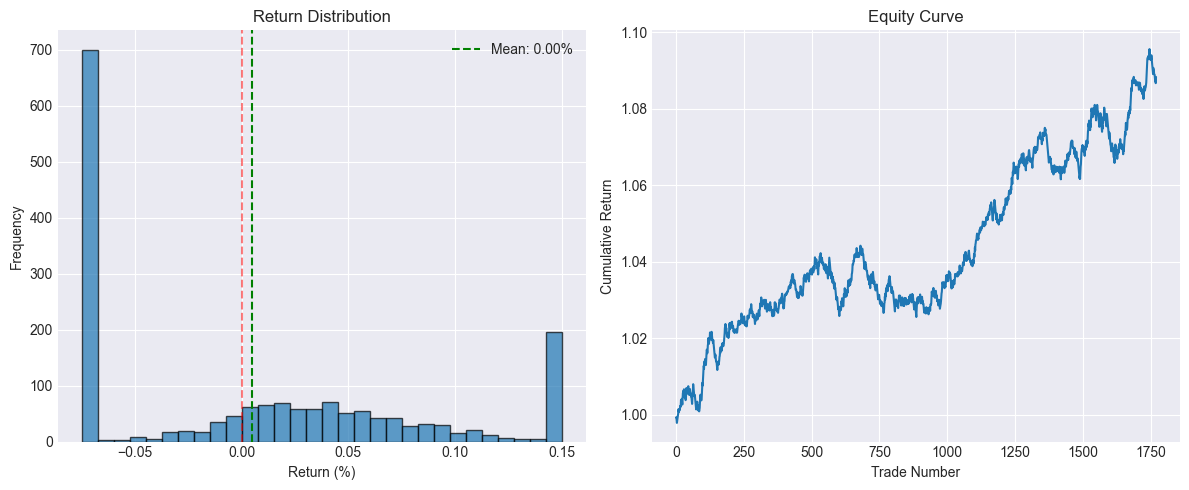

In [7]:
# Calculate performance metrics
if trades_df is not None and len(trades_df) > 0:
    print("=== PERFORMANCE METRICS ===")
    
    # Basic metrics
    total_trades = len(trades_df)
    winning_trades = (trades_df['return_pct'] > 0).sum()
    losing_trades = (trades_df['return_pct'] < 0).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    print(f"\nTotal trades: {total_trades}")
    print(f"Winning trades: {winning_trades}")
    print(f"Losing trades: {losing_trades}")
    print(f"Win rate: {win_rate:.1%}")
    
    # Return metrics
    avg_return = trades_df['return_pct'].mean()
    total_return = trades_df['return_pct'].sum()
    
    if winning_trades > 0:
        avg_win = trades_df[trades_df['return_pct'] > 0]['return_pct'].mean()
    else:
        avg_win = 0
        
    if losing_trades > 0:
        avg_loss = trades_df[trades_df['return_pct'] < 0]['return_pct'].mean()
    else:
        avg_loss = 0
    
    profit_factor = abs(avg_win * winning_trades) / abs(avg_loss * losing_trades) if losing_trades > 0 and avg_loss != 0 else np.inf
    
    print(f"\nAverage return per trade: {avg_return:.2f}%")
    print(f"Total return: {total_return:.2f}%")
    print(f"Average winning trade: {avg_win:.2f}%")
    print(f"Average losing trade: {avg_loss:.2f}%")
    print(f"Profit factor: {profit_factor:.2f}")
    
    # Risk metrics
    returns_std = trades_df['return_pct'].std()
    sharpe_ratio = avg_return / returns_std * np.sqrt(252) if returns_std > 0 else 0  # Annualized
    
    max_dd = 0
    peak = 0
    cumulative_returns = (1 + trades_df['return_pct'] / 100).cumprod()
    for value in cumulative_returns:
        if value > peak:
            peak = value
        dd = (peak - value) / peak
        if dd > max_dd:
            max_dd = dd
    
    print(f"\nSharpe ratio (annualized): {sharpe_ratio:.2f}")
    print(f"Maximum drawdown: {max_dd:.1%}")
    
    # Time metrics
    avg_bars_held = trades_df['bars_held'].mean()
    print(f"\nAverage bars held: {avg_bars_held:.1f}")
    
    # Exit type analysis
    if 'exit_type' in trades_df.columns:
        print("\nExit type breakdown:")
        exit_counts = trades_df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            pct = count / total_trades * 100
            avg_ret = trades_df[trades_df['exit_type'] == exit_type]['return_pct'].mean()
            print(f"  {exit_type}: {count} trades ({pct:.1f}%), avg return: {avg_ret:.2f}%")
    
    # Plot return distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(trades_df['return_pct'], bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', alpha=0.5)
    plt.axvline(avg_return, color='green', linestyle='--', label=f'Mean: {avg_return:.2f}%')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.title('Return Distribution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    cumulative_returns.plot()
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Return')
    plt.title('Equity Curve')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trades available for performance analysis")

## 4. Performance Metrics

In [8]:
if 'position_close' in traces:
    pos_close = traces['position_close']
    print("=== Risk Management Exit Analysis ===")
    print(f"Total positions closed: {len(pos_close)}")
    
    if 'exit_type' in pos_close.columns:
        exit_counts = pos_close['exit_type'].value_counts()
        print("\nExit types:")
        for exit_type, count in exit_counts.items():
            pct = count/len(pos_close)*100
            print(f"  {exit_type}: {count} ({pct:.1f}%)")
    
    if 'exit_reason' in pos_close.columns:
        print("\nSample exit reasons:")
        for i, row in pos_close.head(5).iterrows():
            exit_type = row.get('exit_type', 'unknown')
            exit_reason = row.get('exit_reason', 'unknown')
            print(f"  {exit_type}: {exit_reason}")

In [9]:
# Check if signals persist after risk exits
if 'signals' in traces and 'position_close' in traces:
    signals_df = traces['signals']
    pos_close = traces['position_close']
    
    print("=== Signal Persistence After Risk Exits ===")
    
    # Find risk exits
    if 'exit_type' in pos_close.columns:
        risk_exits = pos_close[pos_close['exit_type'].isin(['stop_loss', 'trailing_stop'])]
        
        if len(risk_exits) > 0:
            print(f"Found {len(risk_exits)} risk exits")
            
            # Check first few risk exits
            for idx, exit_row in risk_exits.head(3).iterrows():
                exit_bar = exit_row['idx']
                
                # Get signals around exit
                next_signals = signals_df[
                    (signals_df['idx'] >= exit_bar) & 
                    (signals_df['idx'] <= exit_bar + 5)
                ]
                
                if len(next_signals) > 0:
                    print(f"\nExit at bar {exit_bar} ({exit_row['exit_type']}):")
                    for _, sig in next_signals.iterrows():
                        print(f"  Bar {sig['idx']}: signal = {sig['val']}")

## 5. Risk Management Exit Analysis

## 8. Summary & Recommendations

## 5. Order Flow Analysis

In [10]:
if 'orders' in traces:
    orders_df = traces['orders']
    print("=== Order Flow Analysis ===")
    print(f"Total orders: {len(orders_df)}")
    
    if len(orders_df) > 1:
        # Calculate time between orders
        order_gaps = orders_df['idx'].diff().dropna()
        
        print(f"\nTime between orders:")
        print(f"  Mean: {order_gaps.mean():.1f} bars")
        print(f"  Median: {order_gaps.median():.1f} bars")
        print(f"  Min: {order_gaps.min():.0f} bars")
        
        # Check for immediate re-entries
        immediate = (order_gaps <= 1).sum()
        print(f"\nImmediate re-entries (≤1 bar): {immediate}")
        
        # Plot distribution
        plt.figure(figsize=(10, 5))
        plt.hist(order_gaps, bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(order_gaps.mean(), color='red', linestyle='--', label=f'Mean: {order_gaps.mean():.1f}')
        plt.axvline(order_gaps.median(), color='green', linestyle='--', label=f'Median: {order_gaps.median():.1f}')
        plt.xlabel('Bars Between Orders')
        plt.ylabel('Frequency')
        plt.title('Time Between Orders Distribution')
        plt.legend()
        plt.show()

## 6. Trade Performance Summary